In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Input, Dense, Embedding, GlobalMaxPool1D, Dropout, SpatialDropout1D
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [38]:
filepath_dict = {'yelp':   'sentiment-analysis/yelp_labelled.txt',
                 'amazon': 'sentiment-analysis/amazon_cells_labelled.txt',
                 'imdb':   'sentiment-analysis/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

In [3]:
df.tail()

,sentence,label,source
743,I just got bored watching Jessice Lange take h...,0,imdb
744,"Unfortunately, any virtue in this film's produ...",0,imdb
745,"In a word, it is embarrassing.",0,imdb
746,Exceptionally bad!,0,imdb
747,All in all its an insult to one's intelligence...,0,imdb


In [9]:
sentences = ['John likes ice cream', 'John hates chocolate.']

In [16]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [18]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]], dtype=int64)

In [5]:
for source in df['source'].unique():

    df_source = df[df['source']==source]
    sentences = df_source['sentence'].values
    labels = df_source['label'].values

    X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25, random_state=42)

    vectorizer = CountVectorizer()
    vectorizer.fit(X_train)

    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)

    print(f'{source:10s}: {classifier.score(X_test, y_test):.3f}')

yelp      : 0.816
amazon    : 0.844
imdb      : 0.727


In [34]:
df_source = df[df['source']=='yelp']
sentences = df_source['sentence'].values
labels = df_source['label'].values
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25, random_state=42)

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [35]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],), name='input_text'),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                17290     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 17,301
Trainable params: 17,301
Non-trainable params: 0
_________________________________________________________________


In [36]:
%%time

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=10,
    verbose=2,
    validation_data=(X_test, y_test)
)

Epoch 1/40
75/75 - 1s - loss: 0.6849 - accuracy: 0.5640 - val_loss: 0.6720 - val_accuracy: 0.6320
Epoch 2/40
75/75 - 0s - loss: 0.6177 - accuracy: 0.8040 - val_loss: 0.6280 - val_accuracy: 0.7000
Epoch 3/40
75/75 - 0s - loss: 0.5218 - accuracy: 0.8667 - val_loss: 0.5707 - val_accuracy: 0.7600
Epoch 4/40
75/75 - 0s - loss: 0.4146 - accuracy: 0.9253 - val_loss: 0.5203 - val_accuracy: 0.7760
Epoch 5/40
75/75 - 0s - loss: 0.3240 - accuracy: 0.9507 - val_loss: 0.4802 - val_accuracy: 0.8040
Epoch 6/40
75/75 - 0s - loss: 0.2560 - accuracy: 0.9667 - val_loss: 0.4518 - val_accuracy: 0.8160
Epoch 7/40
75/75 - 0s - loss: 0.2039 - accuracy: 0.9787 - val_loss: 0.4330 - val_accuracy: 0.8160
Epoch 8/40
75/75 - 0s - loss: 0.1649 - accuracy: 0.9853 - val_loss: 0.4192 - val_accuracy: 0.8200
Epoch 9/40
75/75 - 0s - loss: 0.1350 - accuracy: 0.9893 - val_loss: 0.4137 - val_accuracy: 0.8120
Epoch 10/40
75/75 - 0s - loss: 0.1119 - accuracy: 0.9920 - val_loss: 0.4099 - val_accuracy: 0.8240
Epoch 11/40
75/75 -

In [37]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.8160


In [50]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))
    fig.subplots_adjust(hspace=0.5)
    
    ax1.plot(history['loss'], label='loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_ylim([0, 1])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['accuracy'], label='Accuracy')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

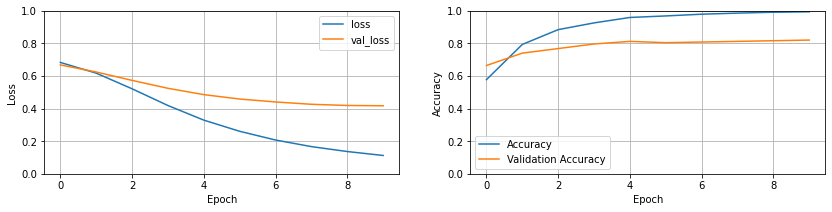

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist
plot_history(hist)

In [18]:
cities = ['London','Brussels','Brussels','London','New York']
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 1, 2], dtype=int64)

In [20]:
encoder_onehot = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((-1,1))
encoder_onehot.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [39]:
# Prep for embeddings
df_source = df[df['source']=='yelp']
sentences = df_source['sentence'].values
labels = df_source['label'].values

# sentences = df['sentence'].values
# labels = df['label'].values
X_sentences_train, X_sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [40]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_sentences_train)

X_train = tokenizer.texts_to_sequences(X_sentences_train)
X_test = tokenizer.texts_to_sequences(X_sentences_test)

vocab_size = len(tokenizer.word_index) + 1


In [41]:
print(X_sentences_train[223])
print(X_train[223])

AN HOUR... seriously?
[46, 252, 240]


In [42]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           221600    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 222,121
Trainable params: 222,121
Non-trainable params: 0
_________________________________________________________________


In [48]:
%%time

history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Epoch 1/5
80/80 - 2s - loss: 0.6966 - accuracy: 0.5025 - val_loss: 0.6926 - val_accuracy: 0.5200
Epoch 2/5
80/80 - 1s - loss: 0.6940 - accuracy: 0.4938 - val_loss: 0.6928 - val_accuracy: 0.5200
Epoch 3/5
80/80 - 1s - loss: 0.6936 - accuracy: 0.4963 - val_loss: 0.6936 - val_accuracy: 0.4800
Epoch 4/5
80/80 - 1s - loss: 0.6938 - accuracy: 0.4775 - val_loss: 0.6935 - val_accuracy: 0.4800
Epoch 5/5
80/80 - 1s - loss: 0.6936 - accuracy: 0.5050 - val_loss: 0.6933 - val_accuracy: 0.4800
Training Accuracy: 0.5050
Testing Accuracy:  0.4800
Wall time: 5.67 s


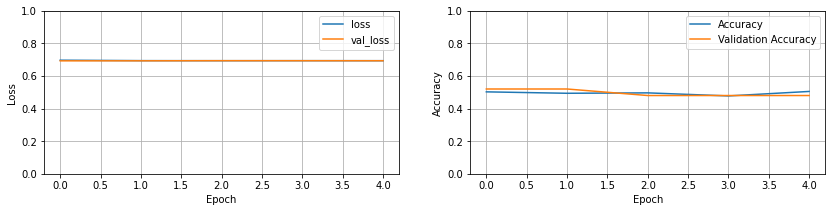

In [51]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist
plot_history(hist)

In [43]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    ''' Read in the GLoVe file and match it up against the word_index
        to optimize the size of the matrix.
    '''
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf8') as f:
        for line in tqdm(f):
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [44]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'glove/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

400001it [00:01, 305665.17it/s]


In [47]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=maxlen,
                    weights=[embedding_matrix], 
                    trainable=True))
# model.add(GlobalMaxPool1D())
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
# model.add(LSTM(100, dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           91250     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               316800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 408,351
Trainable params: 408,351
Non-trainable params: 0
_________________________________________________________________


In [27]:
clear_session()